In [1]:
from data_utils import load_binary_MNIST, load_control_experimental_MNIST
from max_margin import fit_max_margin, evaluate_max_margin
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

colors = ['black','#377eb8', '#ff7f00', '#4daf4a',
              '#984ea3', '#a65628', '#f781bf',
              '#999999', '#e41a1c', '#dede00']
markers = [ 'h', '*', '<', 'o', 's', 'v', 'D' ]

In [2]:
train_set, test_set = load_binary_MNIST()

In [5]:
num_datapoints = [50, 100, 200, 400, 800, 1600, 3200, 6400]
norms = []

for n_data in tqdm(num_datapoints):
    norms += [[]]
    i = 0
    mm_weights, mm_bias = None, None
    while(i < 5 or mm_weights is None):
        indices = np.random.choice(np.arange(train_set['labels'].shape[0]), n_data, replace=False)
        
        with torch.no_grad():
            W = torch.randn((50000, 28*28))
            x, y = train_set['images'][indices], train_set['labels'][indices]
            x = x.view(len(indices), -1)
            x = F.relu(x @ W.T)

        mm_weights, mm_bias = fit_max_margin(x, y, verbose=False)

        if mm_weights is not None:
            i += 1
            print(i, end='\r')
            norms[-1] += [np.linalg.norm(mm_weights)]
        else:
            print("Problem is infeasible with %d samples - resampling train set." % n_data)
        
ys = [np.mean(y) for y in norms]
yerrs = [np.std(y) for y in norms] # Error bars

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:23<02:42, 23.16s/it]

 25%|██▌       | 2/8 [01:06<03:30, 35.17s/it]

 38%|███▊      | 3/8 [02:30<04:47, 57.43s/it]

 50%|█████     | 4/8 [05:39<07:16, 109.19s/it]

 62%|██████▎   | 5/8 [12:50<11:16, 225.48s/it]

 75%|███████▌  | 6/8 [27:56<15:13, 456.73s/it]

 88%|████████▊ | 7/8 [1:06:56<17:52, 1072.50s/it]

100%|██████████| 8/8 [2:27:40<00:00, 1107.59s/it]

<Figure size 360x360 with 0 Axes>

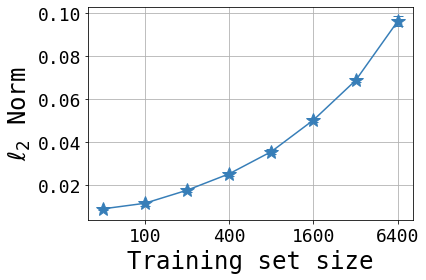

In [6]:
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rcParams['font.family'] ='monospace'
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
ax.set_xlabel('Training set size',fontsize=24)
ax.set_ylabel(r'$\ell_2$ Norm',fontsize=24)
ax.errorbar(x=np.log(num_datapoints),y=ys,yerr= yerrs,marker=markers[1], color=colors[1], 
            capsize=5,markersize=15)
ax.grid()
plt.tight_layout()
plt.xticks(np.log([100, 400, 1600, 6400]), ['100','400','1600','6400'])
plt.savefig(f'plots/mnist_increasing_norms.pdf')

In [9]:
np.save('results/mnist_increasing_norms.npy', np.array(norms))

## Increasing norms: control vs experimental dataset
In the next experiment we are going to validate the following claim of the paper (towards the end of Section 5):
> \[The experimental dataset\] ... has no geometric skews, since merely replicating points does not affect the geometry.

The geometric skew is a direct result of the model selecting solutions that have a lower norm, and thus preferring to learn spurious features (that are present in less datapoints --> lower norm) rather than invariant features (that are present in more datapoints --> higher norm). Merely replicating points with spurious correlation should not increase the norm of the preferred solution.

If the statement from the paper is true, then training on the same amount of random samples from the control dataset and the experimental dataset should result in weights with the same l2 norm.

In [2]:
control, experimental = load_control_experimental_MNIST(spurious_value=0.1)

In [10]:
def get_norms(num_datapoints, train_set):
    norms = []
    ch, w, h = train_set['images'][0].shape

    for n_data in tqdm(num_datapoints):
        norms += [[]]
        i = 0
        mm_weights, mm_bias = None, None
        while(i < 5 or mm_weights is None):
            indices = np.random.choice(np.arange(train_set['labels'].shape[0]), n_data, replace=False)

            with torch.no_grad():
                W = torch.randn((50000, ch*w*h))
                x, y = train_set['images'][indices], train_set['labels'][indices]
                x = x.view(len(indices), -1)
                x = F.relu(x @ W.T)

            mm_weights, mm_bias = fit_max_margin(x, y, verbose=False)

            if mm_weights is not None:
                i += 1
                print(i, end='\r')
                norms[-1] += [np.linalg.norm(mm_weights)]
            else:
                print("Problem is infeasible with %d samples - resampling train set." % n_data)

    return norms

def get_mean_errs(norms):
    ys = [np.mean(y) for y in norms]
    yerrs = [np.std(y) for y in norms] # Error bars
    return ys, yerrs

In [14]:
norms_control = get_norms([50, 100, 200, 400, 800, 1600, 3200, 6400], control)
norms_exp = get_norms([50, 100, 200, 400, 800, 1600, 3200, 6400], experimental)

  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:23<02:42, 23.16s/it]

 25%|██▌       | 2/8 [01:08<03:38, 36.34s/it]

 38%|███▊      | 3/8 [02:34<04:53, 58.78s/it]

 50%|█████     | 4/8 [05:49<07:30, 112.73s/it]

 62%|██████▎   | 5/8 [12:45<11:06, 222.09s/it]

 75%|███████▌  | 6/8 [27:12<14:42, 441.41s/it]

 88%|████████▊ | 7/8 [1:03:01<16:39, 999.64s/it]

100%|██████████| 8/8 [2:23:20<00:00, 1075.12s/it]


  0%|          | 0/8 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [00:31<03:40, 31.51s/it]

 25%|██▌       | 2/8 [01:30<04:45, 47.64s/it]

 38%|███▊      | 3/8 [03:32<06:47, 81.54s/it]

 50%|█████     | 4/8 [08:11<10:37, 159.40s/it]

 62%|██████▎   | 5/8 [17:53<15:35, 311.81s/it]

 75%|███████▌  | 6/8 [37:06<19:56, 598.11s/it]

 88%|████████▊ | 7/8 [1:25:32<22:32, 1352.29s/it]

100%|██████████| 8/8 [3:12:38<00:00, 1444.85s/it]

<Figure size 360x360 with 0 Axes>

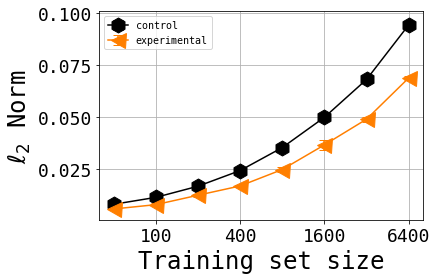

In [17]:
ys_con, yerrs_con = get_mean_errs(norms_control)
ys_exp, yerrs_exp = get_mean_errs(norms_exp)

num_datapoints = [50, 100, 200, 400, 800, 1600, 3200, 6400]

mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rcParams['font.family'] ='monospace'
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
ax.set_xlabel('Training set size',fontsize=24)
ax.set_ylabel(r'$\ell_2$ Norm',fontsize=24)
ax.errorbar(x=np.log(num_datapoints),y=ys_con, yerr=yerrs_con,marker=markers[0], color=colors[0], 
            capsize=5,markersize=15, label='control')

ax.errorbar(x=np.log(num_datapoints),y=ys_exp, yerr=yerrs_exp,marker=markers[2], color=colors[2], 
            capsize=5,markersize=15, label='experimental')

ax.grid()
plt.tight_layout()
plt.xticks(np.log([100, 400, 1600, 6400]), ['100','400','1600','6400'])
plt.legend()
plt.savefig(f'plots/mnist_increasing_norms_2.pdf')